# 🏥 NIH ChestX-ray14 — Dataset Preparation Notebook

This notebook prepares the NIH ChestX-ray14 dataset for transfer-learning experiments.

## 🎯 Goal

We will:

1. Download / place raw NIH ChestX-ray files into `data/raw/`
2. Load metadata & train/val/test split files
3. Inspect raw images
4. Demonstrate preprocessing steps:
   - Load image (1-channel)
   - Convert to RGB (3-channel)
   - Center-crop to square
   - Resize to **224×224**
5. Visualize processed sample
6. Call a **Python script** that:
   ✅ preprocesses full dataset  
   ✅ uses multiprocessing  


⚠️ We only use `.ipynb` for explanation + sample processing,  
**not full dataset conversion** (too slow in notebook).

---


In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

## 📥 1. Load NIH Metadata & Split Files

NIH ChestX-ray14 provides:

- `Data_Entry_2017.csv` → labels
- `train_val_list.txt` → training + validation file names
- `test_list.txt` → test file names

We use these official splits.


In [10]:
RAW_DIR = "../data/raw"

labels_csv = os.path.join(RAW_DIR, "Data_Entry_2017.csv")
trainval_txt = os.path.join(RAW_DIR, "train_val_list.txt")
test_txt = os.path.join(RAW_DIR, "test_list.txt")

df = pd.read_csv(labels_csv)
with open(trainval_txt) as f: trainval_list = [x.strip() for x in f]
with open(test_txt) as f: test_list = [x.strip() for x in f]

len(df), len(trainval_list), len(test_list)


(112120, 86524, 25596)

## 👀 2. Visualize One Sample Image

Let's inspect a raw X-ray image:

- grayscale (1-channel)
- large resolution (~1024×1024)

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

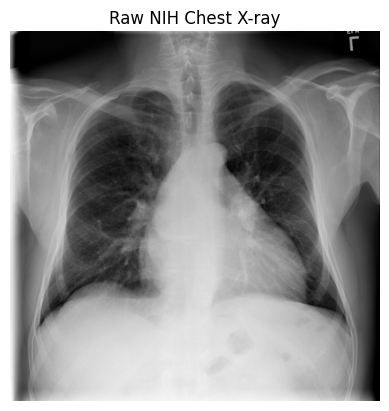

In [14]:
sample_file = os.path.join(RAW_DIR, "images_001", "images", df.iloc[0]["Image Index"])
img = Image.open(sample_file)
plt.imshow(img, cmap="gray")
plt.title("Raw NIH Chest X-ray")
plt.axis("off")

## 🛠 3. Show Preprocessing on a Sample

Steps:

1. Convert grayscale → RGB  
2. Center crop square  
3. Resize to 224×224  

This matches ImageNet pretrained backbones (ResNet, DenseNet).


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

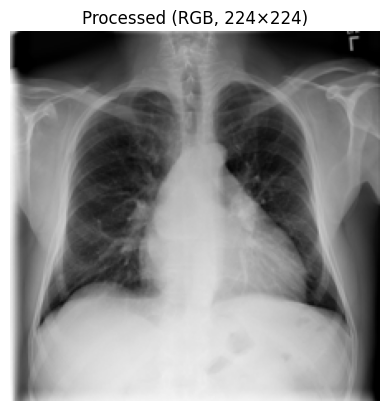

In [15]:
def preprocess_image(pil_img, img_size=224):
    # convert grayscale to RGB
    img = pil_img.convert("RGB")
    
    # square crop
    w, h = img.size
    side = min(w, h)
    left = (w-side)//2
    top = (h-side)//2
    img = img.crop((left, top, left+side, top+side))
    
    # resize
    img = img.resize((img_size, img_size))
    return img

proc = preprocess_image(img)
plt.imshow(proc)
plt.title("Processed (RGB, 224×224)")
plt.axis("off")

## 🏭 4. Run Full Dataset Processing Script

Now that everything is set up, let's prepare the dataset.

The processing script will:

- Read official train/test split files
- Resize and normalize images
- Store results in:
  - `data/processed/train/`
  - `data/processed/val/`
  - `data/processed/test/`

---

### ✅ Run Full Dataset Preparation

#### **Windows (PowerShell)**  

```powershell
python scripts/prepare_dataset.py `
    --input data/raw `
    --output data/processed `
    --img-size 224 `
    --val-split 0.2 `
    --workers 4
```

#### **Linux / macOS / WSL**  

```bash
python3 scripts/prepare_dataset.py \
    --input data/raw \
    --output data/processed \
    --img-size 224 \
    --val-split 0.2 \
    --workers 4
```

### 📦 Output folder structure

Processed dataset will be saved as:

```
data/processed/train/
data/processed/val/
data/processed/test/
```

---

> 💡 **Note:** 
> `data/raw` must contain original NIH files (`images/`, CSV, txt splits)


### 📁 5. Copy Metadata Files & Zip the Processed Dataset (Upload to Google Drive)

After preprocessing finishes, we now package the dataset so it can be reused in Google Colab without reprocessing.

#### What this does
- Copies metadata files (CSV + txt splits) into the processed folder  
- Creates `processed_dataset.zip` (so you don't preprocess again)  
- Saves hours of compute time ✅

---

### ✅ Linux / macOS / WSL

```bash
# Copy metadata files to processed folder
cp data/raw/*.csv data/processed/ 2>/dev/null
cp data/raw/*.txt data/processed/ 2>/dev/null

# Zip processed dataset for Colab use
cd data && zip -r processed_dataset.zip processed && cd ..
```

After this, you will have:

```
data/processed_dataset.zip
```

---

### 🖥️ GUI / File Explorer Method (Linux / macOS / Windows)

If you prefer using a graphical file manager instead of terminal:

1️⃣ Copy all `.csv` & `.txt` files from  
```
data/raw/ → data/processed/
```

2️⃣ Right-click the `data/processed/` folder →  
```
Compress / Zip (Send to → Compressed Folder)
```

---

📤 **Next step**: Upload to Google Drive (manually)

```
data/processed_dataset.zip → Google Drive
```
